# This notebook produces figures from the IPUMS_national_diversities.csv data file 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy as sp
import scipy.stats as stats
import itertools as it
%matplotlib inline

import seaborn as sns

sns.set_palette(sns.color_palette('muted'))

In [3]:
totaldf = pd.read_csv('./IPUMS_ind_occ_state_clean.csv')

In [4]:
#only select decades 1850 - 2010
totaldf = totaldf.loc[totaldf['year'].isin(range(1850,2020,10))]

## make national diversities dataframe 

In [5]:
nat_df = totaldf.groupby(['year'], as_index = False).aggregate({'occ1950':'nunique', 'ind1950':'nunique','stateicp':'nunique', 'pop':'sum'}).rename(columns = {'occ1950':'occ_var', 'ind1950':'ind_var',  'stateicp':'n_states'})

In [6]:
nat_df.head()

,year,occ_var,ind_var,n_states,pop
0,1850,154,121,37,4652267.33
1,1860,187,124,46,7407020.57
2,1870,199,130,48,11753094.60
3,1880,209,135,48,15765571.30
4,1900,237,142,51,25832370.00


In [8]:
totaldf['ind1950'].nunique()

147

In [9]:
totaldf['occ1950'].nunique()

269

In [13]:
def nat_take_entropy(df, year,var, countvar):
#var is variable (either type or feature) over which to take entropy
#countvar is variable that gives the relative frequencies (normalized automatically)

    return sp.stats.entropy( df.loc[df['year']==year].groupby(var)[countvar].sum())
    
    
def nat_take_joint_entropy(df, year, var1, var2, countvar):
#var1, var2 are variables (types or features) over which to take joint entropy
#countvar is variable that gives the relative frequencies (normalized automatically)

    return sp.stats.entropy(df.loc[df['year']==year].groupby([var1,var2])[countvar].sum())

In [14]:
#first compute all entropies 

#H(X)
nat_df['H_occ'] = nat_df.apply(lambda x: nat_take_entropy(totaldf, x['year'], 'occ1950', 'pop' ), axis = 1)

#H(Y)
nat_df['H_ind'] = nat_df.apply(lambda x: nat_take_entropy(totaldf, x['year'], 'ind1950', 'pop' ), axis = 1)

#H(XY)
nat_df['H_occ_ind'] = nat_df.apply(lambda x: nat_take_joint_entropy(totaldf, x['year'], 'ind1950', 'occ1950', 'pop'), axis = 1)

#MI(X,Y)
nat_df['MI_occ_ind'] = nat_df['H_ind'] + nat_df['H_occ'] - nat_df['H_occ_ind'] 

#H(Y|X)
nat_df['H_ind_given_occ'] = nat_df['H_occ_ind'] - nat_df['H_occ']

#H(X|Y)
nat_df['H_occ_given_ind'] = nat_df['H_occ_ind'] - nat_df['H_ind']

In [15]:
#then convert them to diversities 

#D(S) - eff nr of occupations 
nat_df['occ_hill'] = np.exp(nat_df['H_occ'])

#D(S') - eff nr of industries 
nat_df['ind_hill'] = np.exp(nat_df['H_ind'])

#D_{\beta}(S') - nr of compositional units of industries 
nat_df['ind_beta'] = np.exp(nat_df['MI_occ_ind'])

#D_A(S') - variety of industries given by 'ind_var' normalized

#D_B(S') - balance of industries
nat_df['ind_bal'] = np.exp(nat_df['H_ind']) / nat_df['ind_var']

#D_C(S') - disparity of industries 
nat_df['ind_disp'] = np.exp(nat_df['MI_occ_ind']- nat_df['H_ind']) 

In [16]:
nat_df

,year,occ_var,ind_var,n_states,pop,H_occ,H_ind,H_occ_ind,MI_occ_ind,H_ind_given_occ,H_occ_given_ind,occ_hill,ind_hill,ind_beta,ind_bal,ind_disp
0,1850,154,121,37,4.652267e+06,2.331529,2.137916,2.615729,1.853716,0.284200,0.477813,10.293670,8.481740,6.383494,0.070097,0.752616
1,1860,187,124,46,7.407021e+06,2.836851,2.509283,3.182121,2.164013,0.345269,0.672838,17.061960,12.296105,8.706008,0.099162,0.708030
2,1870,199,130,48,1.175309e+07,2.768912,2.457807,3.283739,1.942980,0.514827,0.825931,15.941279,11.679172,6.979522,0.089840,0.597604
3,1880,209,135,48,1.576557e+07,2.843522,2.613348,3.431335,2.025536,0.587813,0.817987,17.176158,13.644660,7.580170,0.101072,0.555541
4,1900,237,142,51,2.583237e+07,3.310244,3.059294,4.084852,2.284687,0.774607,1.025557,27.391819,21.312515,9.822612,0.150088,0.460885
5,1910,257,145,51,3.792548e+07,3.632463,3.436825,5.058995,2.010293,1.426532,1.622170,37.805818,31.088110,7.465506,0.214401,0.240140
6,1920,263,146,51,4.120146e+07,3.793610,3.755551,5.500076,2.049085,1.706466,1.744525,44.416462,42.757771,7.760800,0.292861,0.181506
7,1930,265,147,51,4.864904e+07,3.899265,3.878754,5.803013,1.975006,1.903748,1.924259,49.366136,48.363922,7.206663,0.329006,0.149009
8,1940,213,119,49,5.066073e+07,3.907603,3.892954,5.994759,1.805799,2.087155,2.101804,49.779512,49.055607,6.084833,0.412232,0.124040
9,1950,269,146,49,6.105077e+07,4.108737,4.227349,6.543010,1.793075,2.434274,2.315661,60.869761,68.535324,6.007901,0.469420,0.087661


In [180]:
nat_df.to_csv('./IPUMS_national_diversities.csv')

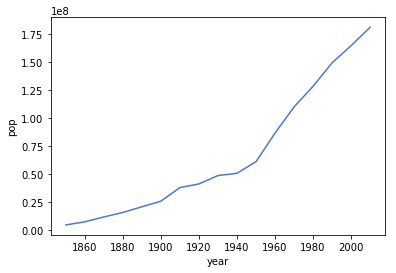

In [181]:
df = nat_df
xvar = 'year'
yvar = 'pop'

plt.figure(1)

df.sort_values(xvar)
plt.plot(df[xvar], df[yvar])


plt.xlabel(xvar)
plt.ylabel(yvar)

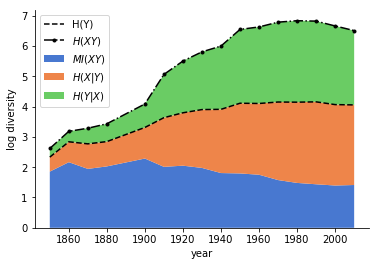

In [220]:
df = nat_df
xvar = 'year'
zvar = 'H_occ_given_ind'
wvar = 'H_ind_given_occ'
yvar = 'MI_occ_ind'

plt.figure(1, frameon = False, dpi = 300)
fig = plt.figure()
#ax = fig.add_axes([0, 0, 1, 1])
#ax.axis('off')


#plt.tick_params(top='off', bottom='on', left='on', right='off', labelleft='off', labelbottom='on')

df.sort_values(xvar)
plt.stackplot(df[xvar], [df[yvar],df[zvar], df[wvar]], labels = ['$MI(XY)$', '$H(X|Y)$', '$H(Y|X)$'])
#plt.stackplot(df[xvar], [df[yvar],df[zvar]], labels = ['$MI(XY)$', '$H(X|Y)$'])
#plt.plot(df[xvar], df[zvar])

plt.plot(df[xvar],df['H_occ'], 'k--', label = 'H(Y)')

#plt.plot(df[xvar],df['H_ind'], 'k--', label = 'H(X)')

plt.plot(df[xvar],df['H_occ_ind'], 'k.-.', label = '$H(XY)$')

plt.xlabel(xvar)
plt.ylabel('log diversity')
plt.legend(loc = 'upper left')

sns.despine(top=True, right=True, left=False, bottom=False)
#plt.savefig('./ind_div_decomp.png', dpi = 300)

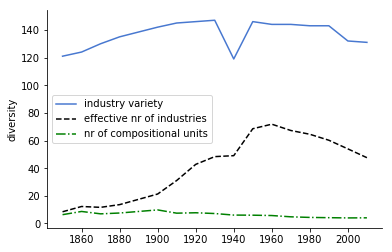

In [221]:
df = nat_df
xvar = 'year'
yvar = 'ind_beta'
zvar = 'ind_hill'
wvar = 'ind_var'

plt.figure(1)

df.sort_values(xvar)

plt.plot(df[xvar], df[wvar], label = 'industry variety')
plt.plot(df[xvar], df[zvar], 'k--', label = 'effective nr of industries')
plt.plot(df[xvar], df[yvar],  'g-.', label = 'nr of compositional units')


sns.despine(top=True, right=True, left=False, bottom=False)
plt.legend()
plt.ylabel('diversity')
#plt.savefig('./ind_div_decomp_divs.png', dpi = 300)

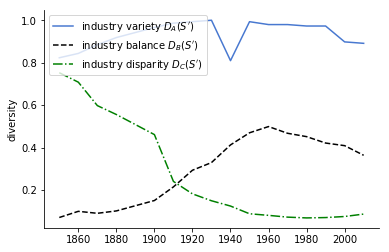

In [17]:
Ni = len(totaldf['ind1950'].unique())

df = nat_df
xvar = 'year'
yvar = 'ind_disp'
zvar = 'ind_bal'
wvar = 'ind_var'

plt.figure(1)

df.sort_values(xvar)

plt.plot(df[xvar], df[wvar]/Ni,  label = 'industry variety $D_A(S\')$')
plt.plot(df[xvar], df[zvar],'k--', label = 'industry balance $D_B(S\')$')
plt.plot(df[xvar], df[yvar], 'g-.', label = 'industry disparity $D_C(S\')$')


sns.despine(top=True, right=True, left=False, bottom=False)
plt.legend(loc = 'upper left')
plt.ylabel('diversity')
#plt.savefig('./ind_div_ABCdecomp.png', dpi = 300)